# Quantify organelle contacts - part 11.4
--------------------

## OVERVIEW
Now that all organelles and masks are segmented, we can begin to quantify features of organelle composition, morphology, contacts, and distribution. 


## OBJECTIVE: ✅ Quantify ***organelle*** contacts
In this notebook, the logic for quantifying organelle contact composition (how much of each contact is present) and morphology (contact site size and shape) is outlined.


## IMPORTS

In [2]:
# top level imports
from pathlib import Path
import os, sys
import itertools

import parse

import napari

from skimage.measure import (regionprops, _regionprops, regionprops_table)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from napari.utils.notebook_display import nbscreenshot

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_my_props_to_dict, _assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH ) 

import time
%load_ext autoreload
%autoreload 2

## Get and load image for quantification
Specifically, this will include the raw image and the outputs from segmentation.

In [3]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

raw_data_path = data_root_path / "raw"
im_type = ".czi"

raw_file_list = list_image_files(raw_data_path,im_type)
raw_img_name = raw_file_list[test_img_n]

# adding an additional list of image paths for the matching segmentation files
seg_data_path = data_root_path / "out"
seg_file_list = list_image_files(seg_data_path, "tiff")

# changing output directory for this notebook to a new folder called "quant"
out_data_path = data_root_path / "quant"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
# raw image
raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [5]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("20230426_test_nuc", raw_meta_dict, seg_data_path)
cell_seg = import_inferred_organelle("20230426_test_cell", raw_meta_dict, seg_data_path)
cyto_seg = import_inferred_organelle("20230426_test_cyto", raw_meta_dict, seg_data_path)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path)

#organelles
lyso_seg = import_inferred_organelle("20230426_test_lyso", raw_meta_dict, seg_data_path)
mito_seg = import_inferred_organelle("20230426_test_mito", raw_meta_dict, seg_data_path)
golgi_seg = import_inferred_organelle("20230426_test_golgi", raw_meta_dict, seg_data_path)
perox_seg = import_inferred_organelle("20230426_test_perox", raw_meta_dict, seg_data_path)
ER_seg = import_inferred_organelle("20230426_test_ER", raw_meta_dict, seg_data_path)
LD_seg = import_inferred_organelle("20230426_test_LD", raw_meta_dict, seg_data_path)


loaded  inferred 3D `20230426_test_nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_lyso`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_mito`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_golgi`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_perox`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_ER`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_LD`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 


-----------------
## **ORGANELLE CONTACTS**

Here we are defining an **organelle contact** as any amount of pixel/voxel overlap between two organelles of different types. The overlap region will be know as the **contact site**. We have implemented a pipeline that identifies two-way contacts, but in reality there exists higher order contacts as well (e.g., three-way, four-way, etc.). Quantification of high order contacts have not been implimented here.

We will utilize similar regionprops measurements as was done to quantify organelle and cell regions morphology.

> NOTE: Since organelle contact sites are smaller than our resolution limit for confocal microscopy, the region of overlap is only an estimation of contacts.
>> It may be helpful to dilate a single organelle (the organelle of interest) before determining the overlap region. This will include any touching, but not overlapping interactions and may improve our ability to detect differences in this subresolution system.

### 1. Create region of overlap between organelle 'a' and organelle 'b'

- **aXb**: organelle a overlapping with organelle b (*NOTE: aXb and bXa overlaps are redundant*)

In [6]:
# creating aXb overlaps
a = _assert_uint16_labels(lyso_seg)
b = _assert_uint16_labels(mito_seg)

a_int_b = np.logical_and(a > 0, b > 0)

test_labels = label(apply_mask(a_int_b, cell_seg)).astype("int")

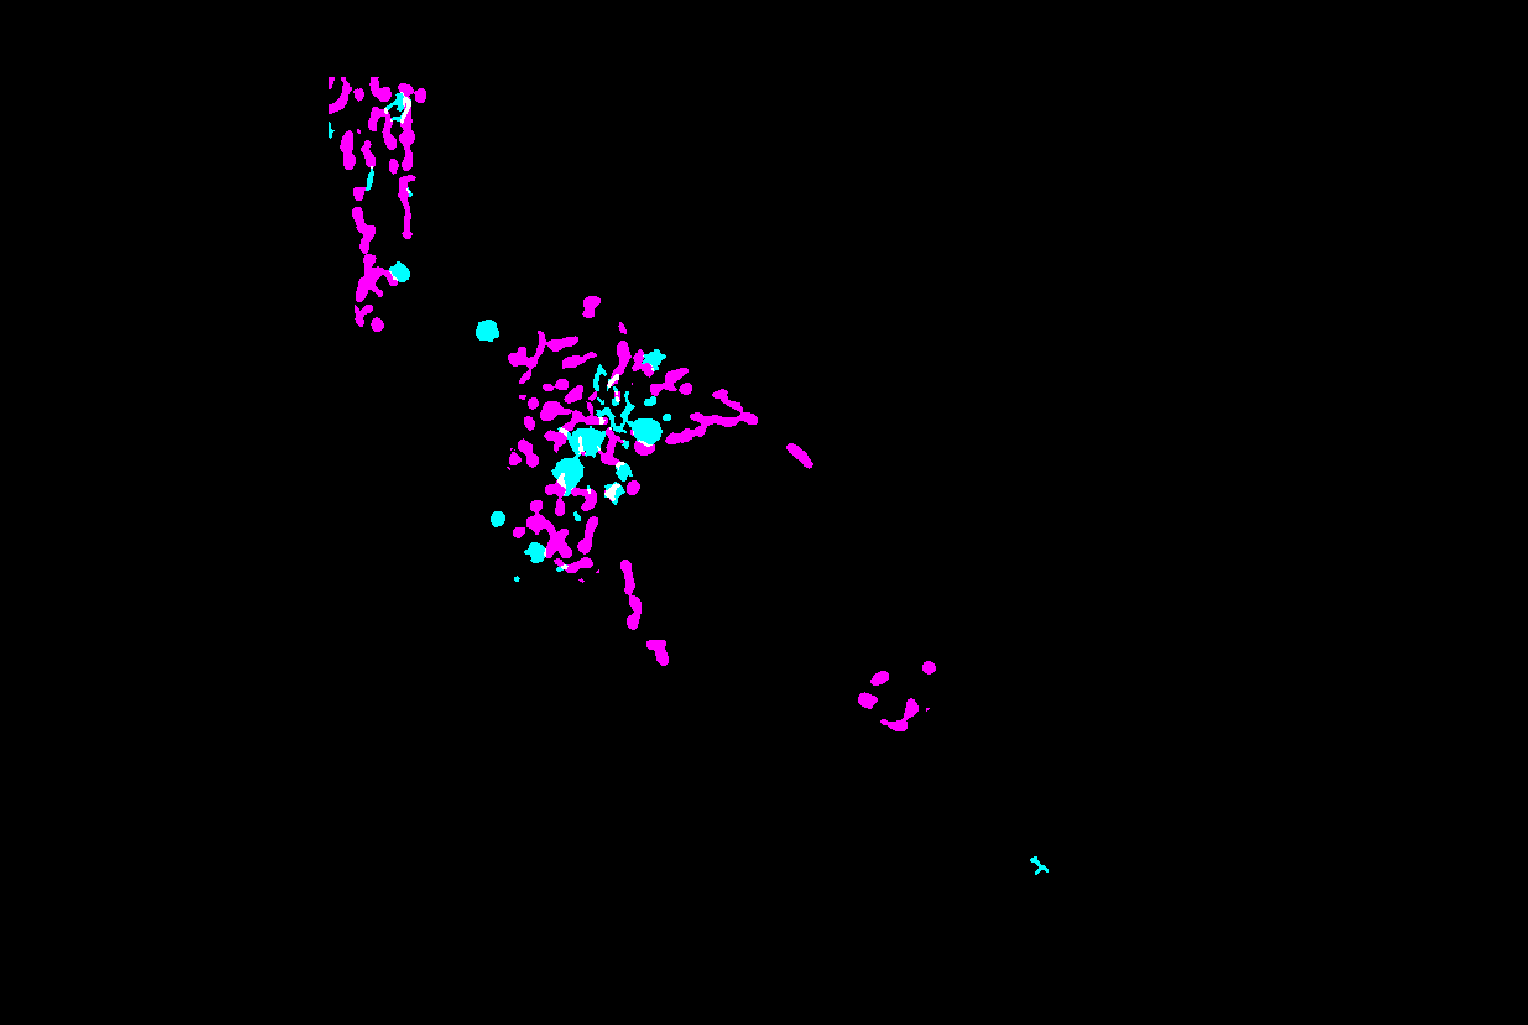

In [7]:
viewer = napari.Viewer()

viewer.add_image(a>0, colormap='cyan', blending ='additive')
viewer.add_image(b>0, colormap='magenta', blending ='additive')
viewer.add_image(test_labels>0, blending ='additive')

nbscreenshot(viewer, canvas_only=True)

In [8]:
viewer.close()

### 2. Build the list of measurements we want to include from regionprops and run regionprops

In [9]:
# start with LABEL
test_Xproperties = ["label"]

# add position
test_Xproperties = test_Xproperties + ["centroid", "bbox"]

# add area
test_Xproperties = test_Xproperties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements - NOTE: can't include minor axis measure because some of the contact sites are only one pixel
test_Xproperties = test_Xproperties + ["extent", "euler_number", "solidity", "axis_major_length", "slice"] # "feret_diameter_max",  , "axis_minor_length"

In [10]:
## NOTE: it may be worth our time to deal with the measurements that having issues with one voxel objects: 
## axis_min_length - the minimum axis of a voxel should be calulated as the minimum axis of a elipsoid with the same central moment as the voxel;
## when scaling this number should be calculated, but without scale, I think this would just be ~1

test_Xprops = regionprops_table(test_labels, 
                                intensity_image=None, 
                                properties=test_Xproperties, 
                                extra_properties=None, 
                                spacing=scale)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1872388660  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.5e-14
  _near-inside 4.2e-13  Visible-distance 2.4e-14  U-max-coplanar 2.4e-14
  Width-outside 4.8e-14  _wide-facet 1.5e-13  _maxoutside 9.7e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Fa

In [11]:
test_Xsurface_area_tab = pd.DataFrame(surface_area_from_props(test_labels, test_Xprops, scale=scale))

### 3. Track which individual organelles are involved in that contact.

In [12]:
# collecting a list of organelle IDs associated to each contact site
test_label_a = []
test_index_ab = []
test_label_b = []
for index, lab in enumerate(test_Xprops["label"]):
    # this seems less elegant than you might wish, given that regionprops returns a slice,
    # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
    volume = test_labels[test_Xprops["slice"][index]]
    la = a[test_Xprops["slice"][index]]
    lb = b[test_Xprops["slice"][index]]
    volume = volume == lab
    la = la[volume]
    lb = lb[volume]

    all_as = np.unique(la[la>0]).tolist()
    all_bs = np.unique(lb[lb>0]).tolist()
    if len(all_as) != 1:
        print(f"we have an error.  as-> {all_as}")
    if len(all_bs) != 1:
        print(f"we have an error.  bs-> {all_bs}")

    test_label_a.append(all_as[0])
    test_label_b.append(all_bs[0])
    test_index_ab.append(f"{all_as[0]}_{all_bs[0]}")

In [13]:
test_org_a = "lyso"
test_org_b = "mito"

test_Xprops_table = pd.DataFrame(test_Xprops)
test_Xprops_table.drop(columns=["slice", "label"], inplace=True)
test_Xprops_table.insert(0, 'label',value=test_index_ab)
test_Xprops_table.insert(0, "object", f"{test_org_a}X{test_org_b}")
test_Xprops_table.rename(columns={"area": "volume"}, inplace=True)

test_Xprops_table.insert(11, "surface_area", test_Xsurface_area_tab)
test_Xprops_table.insert(13, "SA_to_volume_ratio", test_Xprops_table["surface_area"].div(test_Xprops_table["volume"]))

test_scale = scale

if test_scale is not None:
    test_round_scale = (round(test_scale[0], 4), round(test_scale[1], 4), round(test_scale[2], 4))
    test_Xprops_table.insert(loc=2, column="scale", value=f"{test_round_scale}")
else: 
    test_Xprops_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(test_labels.ndim))}") 

test_Xprops_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length
0,lysoXmito,3_2,"(0.3891, 0.0799, 0.0799)",0.000000,22.670667,16.512820,0,279,203,1,289,210,1.025384,0.076954,13.324701,0.527728,0.442857,1,inf,0.792587
1,lysoXmito,4_2,"(0.3891, 0.0799, 0.0799)",0.345883,28.017201,22.932039,0,349,286,2,354,289,0.823862,0.022341,36.876082,0.349438,0.300000,1,0.750000,0.642565
2,lysoXmito,11_2,"(0.3891, 0.0799, 0.0799)",0.661501,22.808681,15.875822,1,283,195,3,289,203,2.345016,0.074471,31.488889,0.521991,0.312500,0,0.517241,1.063336
3,lysoXmito,14_2,"(0.3891, 0.0799, 0.0799)",0.933884,26.316822,20.384133,1,325,251,4,334,260,3.320444,0.223414,14.862315,0.752842,0.370370,1,0.769231,1.020799
4,lysoXmito,26_2,"(0.3891, 0.0799, 0.0799)",2.353893,23.447392,16.789077,2,281,201,9,305,225,13.182195,0.704994,18.698303,1.104237,0.070437,1,0.250220,3.765527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,lysoXmito,26_2,"(0.3891, 0.0799, 0.0799)",4.669422,21.525410,18.130865,12,269,227,13,271,228,0.304565,0.004965,61.345452,0.211657,1.000000,1,inf,0.178598
95,lysoXmito,109_2,"(0.3891, 0.0799, 0.0799)",5.280894,23.626795,23.195108,13,292,286,16,299,295,2.513013,0.104260,24.103398,0.583946,0.222222,1,0.600000,1.247478
96,lysoXmito,116_2,"(0.3891, 0.0799, 0.0799)",5.836777,16.852919,16.293817,15,211,204,16,212,205,0.177655,0.002482,71.566426,0.167992,1.000000,1,inf,0.000000
97,lysoXmito,117_2,"(0.3891, 0.0799, 0.0799)",5.836777,20.216403,16.675426,15,249,207,16,257,212,1.542447,0.044683,34.519989,0.440265,0.450000,1,inf,0.845828


#### `WIP`: Adding a "SHELL" measurement for each contact site, we want to measure the membrane surface area from each organelle involved in the contact

I think the most logical way to do this seems to be using marching_cubes to create an isosurface of each object (org A, org B, and the intersection), then cut the orgs' isosurface using the overlap region. The isosurface region of intersection between the org and the overlap will be measured as the membrane in contact.

- **shell_aXb**: the "shell", or membrane, of organelle a overlapping with organelle b (*NOTE: shell_aXb and shellbXa are *NOT* redundant*)

In [14]:
# # creating shell_aXb overlaps
# # We need to conside how to do this correctly as creating a "shell" by eroding the object doesn't make sense 
# # since our data is anisotropic

# a_shell_int_b = np.logical_and(np.logical_xor(a > 0, binary_erosion(a > 0)), b > 0)
# test_shell_labels = label(apply_mask(a_shell_int_b, cell_seg)).astype("int")

In [15]:
# viewer = napari.Viewer()

In [16]:
# # does marhcing cubes create iso surfaces for all object in the FOV? yes
# test_verts, test_faces, test__normals, test__values = marching_cubes(mito_seg,
#                                                     method="lewiner",
#                                                     spacing=scale,
#                                                     level=0)

# viewer.add_surface((test_verts, test_faces), scale=scale, name='mito_surfaces')

<Surface layer 'mito_surfaces' at 0x1a1828b4610>

In [17]:
# test_obj1 = test_labels==1

In [18]:
# # apply the overlap region as the mask - this can be done using the entire image worth of objects, but they won't be able to be separated based on which objects the originated from
# test_verts, test_faces, test__normals, test__values = marching_cubes(mito_seg.astype(bool),
#                                                     method="lewiner",
#                                                     spacing=scale,
#                                                     level=0,)
#                                                     # mask=test_obj1)

# # test_mesh = Poly3DCollection(test_verts[test_faces])
# # test_mesh_masked = test_mesh[~test_obj1]=0

# test_vfaces = np.column_stack((np.ones(len(test_faces),) * 3, test_faces)).astype(int)

# # viewer.add_surface((test_verts, test_faces), scale=scale, name='mito_overlap_surfaces', colormap='red')

In [19]:
# import pyvista as pv

In [20]:
# # what is we created two isosurfaces - one of the intersected region and one of the main objects - and found where they intersect each other only
# test_mito_verts, test_mito_faces, test__normals, test__values = marching_cubes(mito_seg,
#                                                     method="lewiner",
#                                                     spacing=scale,
#                                                     level=0,)
# test_mito_vfaces = np.column_stack((np.ones(len(test_mito_faces),) * 3, test_mito_faces)).astype(int)
# test_mito_mesh = pv.PolyData(test_mito_verts, test_mito_vfaces)

# test_overlap1_verts, test_overlap1_faces, test__normals, test__values = marching_cubes(test_obj1,
#                                                     method="lewiner",
#                                                     spacing=scale,
#                                                     level=0,)
# test_overlap1_vfaces = np.column_stack((np.ones(len(test_overlap1_faces),) * 3, test_overlap1_faces)).astype(int)
# test_obj1_mesh = pv.PolyData(test_overlap1_verts, test_overlap1_vfaces)

In [ ]:
# try to get this example code to work: https://docs.pyvista.org/version/stable/api/core/_autosummary/pyvista.PolyDataFilters.intersection.html

In [21]:
# intersec, s1_plit, s2_split = test_mito_mesh.intersection(test_obj1_mesh, progress_bar=True)

Computing the intersection between two meshes:   0%|          [00:00<?]

: 

In [21]:
# test_mito_mesh.
# .PolyDataFilters.intersction(test_obj1_mesh, split_first=True)

In [22]:
# viewer.add_image(mito_seg, colormap='green')
# viewer.add_image(lyso_seg, colormap='cyan')

In [23]:
# # loop through each overlap region and apply it as the mask to general a final surface measurement
# test_surface_areas = {}
# for test_cross in np.unique(test_labels)[2:]:
#     print(test_cross)
#     test_Xsite = test_labels==test_cross
#     test_verts, test_faces, test__normals, test__values = marching_cubes(mito_masked,
#                                                     method="lewiner",
#                                                     spacing=scale,
#                                                     level=0,
#                                                     mask=test_Xsite)
#     test_surface_areas[f"{test_cross}_A"] = mesh_surface_area(test_verts, test_faces)
# test_surface_areas

In [24]:
## creating a function to measure the surface area of each object. This function utilizes "marching_cubes" to generate a mesh (non-pixelated object)
## the main issue I am running into here is that I can't figure out how to create the mesh with the same exact scale as the 

# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def _surface_area_from_props_membrane_in_contact(labels: np.ndarray,
#                              props: dict,
#                              spacing: Union[tuple, None]=None):
#     """ 
#     a function for getting surface area of volumetric objects

#     Parameters:
#     ----------
#     lables:
#         the segmentation np.ndarray with each object labeled a different number
#     props:
#         region props dictionary resulting from the _my_props_to_dict() function
#     spacing:
#         tuple of the dimension lengths in the same order as the dimension of your np.ndarray labels input
#     """
    
#     if spacing is None:
#         spacing = np.ones(labels.ndim)

#     surface_areas = np.zeros(len(props["label"]))

#     for lab in np.unique(labels)[1:]:
#         volume = labels == lab
#         verts, faces, _normals, _values = marching_cubes(volume,
#                                                          method="lewiner",
#                                                          spacing=spacing,
#                                                          level=0)
        
#         mesh = Poly3DCollection(verts[faces])
        
#         # surface_areas[index] = mesh_surface_area(verts, faces)

#     return surface_areas

In [25]:
# nuc_masked = apply_mask(nuc_seg, cell_seg)

# test_list_of_objs = np.unique(nuc_masked)[1:]

# alt_new_test_volume = nuc_masked == test_list_of_objs[0]



# test_verts, test_faces, test__normals, test__values = marching_cubes(golgi_seg,
#                                                     method="lewiner",
#                                                     spacing=scale,
#                                                     level=0)

# test_mesh = Poly3DCollection(test_verts[test_faces])


In [26]:
# viewer.add_image(alt_new_test_volume, scale=scale)


In [27]:
# test_Xprops_tab_combined = pd.DataFrame(test_Xprops)

# test_Xprops_tab_combined

In [28]:
# test_org_a = "lyso"
# test_org_b = "mito"
# test_Xprops_tab_combined.insert(11, "surface_area", test_Xsurface_area_tab)
# test_Xprops_tab_combined.insert(1, "org_B_label", test_label_b)
# test_Xprops_tab_combined.insert(1, "org_B", test_org_b)
# test_Xprops_tab_combined.insert(1, "org_A_label", test_label_a)
# test_Xprops_tab_combined.insert(1, "org_A", test_org_a)
# test_Xprops_tab_combined.insert(0,column='X_label',value=test_index_ab)
# test_Xprops_tab_combined.rename(columns={"area": "volume"}, inplace=True)
# test_Xprops_tab_combined.drop(columns="slice", inplace=True)

# test_Xprops_tab_combined

In [29]:
# test_a_shell_tab = pd.DataFrame(test_a_shell_Xprops)

# test_a_shell_tab.rename(columns={"area": "shell_a_volume"}, inplace=True)
# test_a_shell_tab.rename(columns={"equivalent_diameter": "shell_a_equivalent_diameter"}, inplace=True)
# test_a_shell_tab.rename(columns={"extent": "shell_a_extent"}, inplace=True)
# test_a_shell_tab.rename(columns={"euler_number": "shell_a_euler_number"}, inplace=True)
# test_a_shell_tab.rename(columns={"convex_area": "shell_a_convex_area"}, inplace=True)
# test_a_shell_tab.rename(columns={"solidity": "shell_a_solidity"}, inplace=True)
# test_a_shell_tab.rename(columns={"axis_major_length": "shell_a_axis_major_length"}, inplace=True)

# test_a_shell_tab

In [30]:
# new_shell_a_tab = test_a_shell_tab.loc[:, 'shell_a_volume':'shell_a_axis_major_length']
# new_shell_a_tab.insert(0,column='X_label',value=test_index_ab)
# new_shell_a_tab

In [31]:
# new_comboXtab = pd.merge(test_Xprops_tab_combined, new_shell_a_tab, on='X_label')
# new_comboXtab

In [32]:
# test_b_shell_tab = pd.DataFrame(test_b_shell_Xprops)
# test_b_shell_tab

In [33]:


# test_b_shell_tab.rename(columns={"area": "shell_b_volume"}, inplace=True)
# test_b_shell_tab.rename(columns={"equivalent_diameter": "shell_b_equivalent_diameter"}, inplace=True)
# test_b_shell_tab.rename(columns={"extent": "shell_b_extent"}, inplace=True)
# test_b_shell_tab.rename(columns={"euler_number": "shell_b_euler_number"}, inplace=True)
# test_b_shell_tab.rename(columns={"convex_area": "shell_b_convex_area"}, inplace=True)
# test_b_shell_tab.rename(columns={"solidity": "shell_b_solidity"}, inplace=True)
# test_b_shell_tab.rename(columns={"axis_major_length": "shell_b_axis_major_length"}, inplace=True)

# new_shell_b_tab = test_b_shell_tab.loc[:, 'shell_b_volume':'shell_b_axis_major_length']
# new_shell_b_tab.insert(0,column='X_label',value=test_index_ab)
# new_shell_b_tab

In [34]:
# test_b_shell_tab = pd.DataFrame(test_b_shell_Xprops)

In [35]:
## The logic behind this is that for each contact site (region of overlap between unique organelles),
## we will also collect information from the "shell" or membrane from both organelles in that contact.

# a_int_b = np.logical_and(a > 0, b > 0)
# test_labels = label(apply_mask(a_int_b, cell_seg)).astype("int")

# a_shell_int_b = np.logical_and(np.logical_xor(a > 0, binary_erosion(a > 0)), b > 0)
# test_a_shell_labels = label(apply_mask(a_shell_int_b, cell_seg)).astype("int")

# b_shell_int_a = np.logical_and(np.logical_xor(b > 0, binary_erosion(b > 0)), a > 0)
# test_b_shell_labels = label(apply_mask(b_shell_int_a, cell_seg)).astype("int")

In [36]:
# viewer = napari.Viewer()

In [37]:
# viewer.add_image(test_labels, colormap='gray')
# viewer.add_image(test_a_shell_labels, colormap='green', opacity=0.5)
# viewer.add_image(test_b_shell_labels, colormap='red', opacity=0.5)

In [38]:
# np.unique(test_labels), np.unique(test_a_shell_labels), np.unique(test_b_shell_labels)

In [39]:
# # For testing adding the shell contacts to the main contacts table
# test_a_shell_Xprops = regionprops_table(test_a_shell_labels, intensity_image=None, properties=test_Xproperties, extra_properties=None)
# test_b_shell_Xprops = regionprops_table(test_b_shell_labels, intensity_image=None, properties=test_Xproperties, extra_properties=None)

In [40]:
# use_shell_a = False #True = use shell, False = no shell

# test_Xprops["label_A"] = test_label_a ## TODO: FIND A WAY TO INSERT ACTUAL ORGANELLE NAME, NOT "a" OR "b"
# test_Xprops["label_b"] = test_label_b
# test_Xprops_table = pd.DataFrame(test_Xprops)
# test_Xprops_table.insert(11, "surface_area", test_Xsurface_area_tab)
# test_Xprops_table.rename(columns={"area": "volume"}, inplace=True)
# test_Xprops_table.drop(columns="slice", inplace=True)
# test_Xprops_table.insert(loc=0,column='label_',value=test_index_ab) # do we need this is every row already has columns for each organelle and ID
# test_Xprops_table.insert(loc=0,column='shell',value=use_shell_a)

# use_shell_a = False #True = use shell, False = no shell
# if use_shell_a is True:
#     test_Xprops_table.insert(loc=0,column='shell',value=use_shell_a)

### 4. Define `get_contact_metrics_3D()` function

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [49]:
def _get_contact_metrics_3D(a: np.ndarray,
                            a_name: str, 
                            b: np.ndarray, 
                            b_name:str, 
                            mask: np.ndarray, 
                            scale: Union[tuple, None]=None,
                            include_dist:bool=False, 
                            dist_centering_obj: Union[np.ndarray, None]=None,
                            dist_num_bins: Union[int, None]=None,
                            dist_zernike_degrees: Union[int, None]=None,
                            dist_center_on: Union[bool, None]=None,
                            dist_keep_center_as_bin: Union[bool, None]=None):
    """
    collect volumentric measurements of organelle `a` intersect organelle `b`

    Parameters
    ------------
    a: np.ndarray
        3D (ZYX) np.ndarray of one set of objects that will be assessed as part of a "contact"
    a_name: str
        the name or nickname of object a; this will be used for record keeping purposed in the output dataframe 
    b: np.ndarray
        3D (ZYX) np.ndarray of one set of objects that will be assessed as part of a "contact"
    b_name: str
        the name or nickname of object b; this will be used for record keeping purposed in the output dataframe 
    mask: np.ndarray
        3D (ZYX) binary mask of the area to measure contacts from
    include_dist:bool=False
        *optional*
        True = include the XY and Z distribution measurements of the contact sites within the masked region 
        (utilizing the functions get_XY_distribution() and get_Z_distribution() from Infer-subc)
        False = do not include distirbution measurements
    dist_centering_obj: Union[np.ndarray, None]=None
        ONLY NEEDED IF include_dist=True; if None, the center of the mask will be used
        3D (ZYX) np.ndarray containing the object to use for centering the XY distribution mask
    dist_num_bins: Union[int, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is 5
    dist_zernike_degrees: Unions[int, None]=None,
        ONLY NEEDED IF include_dist=True; if None, the zernike share measurements will not be included in the distribution
        the number of zernike degrees to include for the zernike shape descriptors
    dist_center_on: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is False
        True = distribute the bins from the center of the centering object
        False = distribute the bins from the edge of the centering object
    dist_keep_center_as_bin: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is True
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins


    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length']

    Additional measurements:
    ----------------------
    ['surface_area']

    
    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each overlap region between a and b (rows)
    
    """
    
    #########################
    ## CREATE OVERLAP REGIONS
    #########################
    a = _assert_uint16_labels(a)
    b = _assert_uint16_labels(b)

    a_int_b = np.logical_and(a > 0, b > 0)

    labels = label(apply_mask(a_int_b, mask)).astype("int")

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length", "slice"] # "feret_diameter_max", "axis_minor_length", 

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(labels, intensity_image=None, properties=properties, extra_properties=None, spacing=scale)

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(surface_area_from_props(labels, props, scale))

    ######################################################
    ## LIST WHICH ORGANELLES ARE INVOLVED IN THE CONTACTS
    ######################################################
    label_a = []
    index_ab = []
    label_b = []
    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[props["slice"][index]]
        la = a[props["slice"][index]]
        lb = b[props["slice"][index]]
        volume = volume == lab
        la = la[volume]
        lb = lb[volume]

        all_as = np.unique(la[la>0]).tolist()
        all_bs = np.unique(lb[lb>0]).tolist()
        if len(all_as) != 1:
            print(f"we have an error.  as-> {all_as}")
        if len(all_bs) != 1:
            print(f"we have an error.  bs-> {all_bs}")

        label_a.append(f"{all_as[0]}" )
        label_b.append(f"{all_bs[0]}" )
        index_ab.append(f"{all_as[0]}_{all_bs[0]}")


    ######################################################
    ## CREATE COMBINED DATAFRAME OF THE QUANTIFICATION
    ######################################################
    props_table = pd.DataFrame(props)
    props_table.drop(columns=['slice', 'label'], inplace=True)
    props_table.insert(0, 'label',value=index_ab)
    props_table.insert(0, "object", f"{a_name}X{b_name}")
    props_table.rename(columns={"area": "volume"}, inplace=True)

    props_table.insert(11, "surface_area", surface_area_tab)
    props_table.insert(13, "SA_to_volume_raiot", props_table["surface_area"].div(props_table["volume"]))

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(labels.ndim))}") 


    ######################################################
    ## optional: DISTRIBUTION OF CONTACTS MEASUREMENTS
    ######################################################
    if include_dist is True:
        XY_contact_dist, XY_bins, XY_wedges = get_XY_distribution(mask=mask, 
                                                                  obj=a_int_b,
                                                                  obj_name=f"{a_name}X{b_name}",
                                                                  centering_obj=dist_centering_obj,
                                                                  scale=scale,
                                                                  center_on=dist_center_on,
                                                                  keep_center_as_bin=dist_keep_center_as_bin,
                                                                  num_bins=dist_num_bins,
                                                                  zernike_degrees=dist_zernike_degrees)
        
        Z_contact_dist = get_Z_distribution(mask=mask,
                                            obj=a_int_b,
                                            obj_name=f"{a_name}X{b_name}",
                                            center_obj=dist_centering_obj,
                                            scale=scale)
        
        contact_dist_tab = pd.merge(XY_contact_dist, Z_contact_dist, on=["object", "scale"])

        return props_table, contact_dist_tab
    else:
        return props_table

In [50]:
lysoXmito_stat_tab_test, test_cont_dist_tab = _get_contact_metrics_3D(a=lyso_seg, a_name='lyso', 
                                                                      b=mito_seg, b_name='mito', 
                                                                      mask=cell_seg, 
                                                                      scale=scale,
                                                                      include_dist=True, 
                                                                      dist_centering_obj=nuc_seg,
                                                                      dist_center_on=False,
                                                                      dist_keep_center_as_bin=True,
                                                                      dist_num_bins=5,
                                                                      dist_zernike_degrees=9)

lysoXmito_stat_tab_test.equals(test_Xprops_table)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 519979791  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.5e-14
  _near-inside 4.2e-13  Visible-distance 2.4e-14  U-max-coplanar 2.4e-14
  Width-outside 4.8e-14  _wide-facet 1.5e-13  _maxoutside 9.7e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Fai

True

In [51]:
test_cont_dist_tab

,object,scale,XY_n_bins,XY_bins,XY_mask_vol_perbin,XY_obj_vol_perbin,XY_center_vol_perbin,XY_area_perbin,XY_portion_pix_perbin,XY_n_wedges,...,zernike_mask_phs,zernike_obj_mag,zernike_obj_phs,zernike_center_mag,zernike_center_phs,Z_n_slices,Z_height,Z_mask_volume,Z_obj_volume,Z_center_volume
0,lysoXmito,"(0.3891, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[1384.2287867207706, 359.2466698565934, 514.07...","[0.3227086082778153, 2.0851940842566523, 3.822...","[1037.508175613176, 0.0, 0.0, 0.0, 0.0]","[225.5529220683303, 64.52844797831092, 100.885...","[0.21907181361918335, 0.06267426730280687, 0.0...",8,...,"[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.16241016701170818, 0.9082512957565915,...","[1.5707963267948966, -1.989741686393458, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,6.615014,"[199.4140609244112, 234.83257186985634, 241.01...","[0.07943596511453914, 0.049647478196586964, 0....","[30.289926447737706, 62.64767036236326, 71.929..."


### Add prototype function into `stats.py`

In [48]:
from infer_subc.utils.stats import get_contact_metrics_3D

lysoXmito_stat_tab_final, test_cont_dist_tab_final = get_contact_metrics_3D(a=lyso_seg, a_name='lyso', 
                                                                      b=mito_seg, b_name='mito', 
                                                                      mask=cell_seg, 
                                                                      scale=scale,
                                                                      include_dist=True, 
                                                                      dist_centering_obj=nuc_seg,
                                                                      dist_center_on=False,
                                                                      dist_keep_center_as_bin=True,
                                                                      dist_num_bins=5,
                                                                      dist_zernike_degrees=9)

lysoXmito_stat_tab_test.equals(lysoXmito_stat_tab_final), test_cont_dist_tab.equals(test_cont_dist_tab_final)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 518920950  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.5e-14
  _near-inside 4.2e-13  Visible-distance 2.4e-14  U-max-coplanar 2.4e-14
  Width-outside 4.8e-14  _wide-facet 1.5e-13  _maxoutside 9.7e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Fai

(True, True)